# Bird Classification using ResNet50 + ArcFace
## Based on "Transferring Face Recognition Techniques to Entomology" Paper

This notebook implements the methodology from the dragonfly classification paper, adapting face recognition techniques (ArcFace loss) for bird species classification.

**Key Features:**
- ResNet50 backbone with pretrained weights
- ArcFace loss function for improved inter-class separation
- Comparison with standard ResNet50 + Softmax
- Similarity-based prediction with confidence thresholds
- Adapted for smaller dataset (1082 train, 103 val samples, 20 classes)

## 1. Setup and Installation

In [1]:
# Install required packages
!pip install -q torch torchvision timm albumentations opencv-python-headless scikit-learn matplotlib seaborn pandas numpy tqdm pillow

In [2]:
# Mount Google Drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## 2. Imports

In [3]:
import os
import sys
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from PIL import Image
from tqdm.auto import tqdm
import cv2
from collections import defaultdict, Counter
import json
import copy
import warnings
warnings.filterwarnings('ignore')

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as T
from torchvision import models
from torch.optim import SGD
from torch.optim.lr_scheduler import StepLR

import albumentations as A
from albumentations.pytorch import ToTensorV2
from sklearn.metrics import classification_report, confusion_matrix, precision_recall_fscore_support

# Set style
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")

print(f"PyTorch version: {torch.__version__}")
print(f"CUDA available: {torch.cuda.is_available()}")
if torch.cuda.is_available():
    print(f"CUDA device: {torch.cuda.get_device_name(0)}")

PyTorch version: 2.9.0+cu126
CUDA available: True
CUDA device: Tesla T4


## 3. Configuration and Setup

In [4]:
# Set random seeds for reproducibility
def set_seed(seed=42):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

set_seed(42)
print("✓ Random seed set to 42")

✓ Random seed set to 42


In [5]:
# ⚠️ UPDATE THIS PATH based on where you uploaded your data in Google Drive
DATA_DIR = '/content/drive/MyDrive/data'  # Change this to your actual path

# Metadata CSV files
TRAIN_METADATA = f'{DATA_DIR}/train_metadata.csv'
VAL_METADATA = f'{DATA_DIR}/val_metadata.csv'

# Image directories
TRAIN_IMAGES_DIR = f'{DATA_DIR}/train_images'
VAL_IMAGES_DIR = f'{DATA_DIR}/val_images'
TEST_IMAGES_DIR = f'{DATA_DIR}/test_images'

# Output directories (saved to Google Drive)
CHECKPOINT_DIR = '/content/drive/MyDrive/bird_checkpoints'
RESULTS_DIR = '/content/drive/MyDrive/bird_results'

os.makedirs(CHECKPOINT_DIR, exist_ok=True)
os.makedirs(RESULTS_DIR, exist_ok=True)

# Verify paths
print("=" * 70)
print("CHECKING DATA DIRECTORIES")
print("=" * 70)
for path, name in [(TRAIN_METADATA, 'Train Metadata'),
                    (VAL_METADATA, 'Val Metadata'),
                    (TRAIN_IMAGES_DIR, 'Train Images'),
                    (VAL_IMAGES_DIR, 'Val Images'),
                    (TEST_IMAGES_DIR, 'Test Images')]:
    if os.path.exists(path):
        print(f"✓ {name}: {path}")
    else:
        print(f"✗ {name}: {path} (NOT FOUND - please update path!)")
print("=" * 70)

CHECKING DATA DIRECTORIES
✓ Train Metadata: /content/drive/MyDrive/data/train_metadata.csv
✓ Val Metadata: /content/drive/MyDrive/data/val_metadata.csv
✓ Train Images: /content/drive/MyDrive/data/train_images
✓ Val Images: /content/drive/MyDrive/data/val_images
✓ Test Images: /content/drive/MyDrive/data/test_images


In [1]:
# Configuration (adapted from paper for smaller dataset)
class Config:
    # Data settings (same as paper)
    img_size = 128  # Paper uses 128x128
    num_workers = 2

    # Model settings (same as paper)
    backbone = 'resnet50'
    embedding_size = 512  # Paper uses 512-dim features
    pretrained = True

    # Training settings (adjusted for smaller dataset)
    batch_size = 32  # Reduced from paper's 256 due to smaller dataset
    num_epochs = 100  # Same as paper
    learning_rate = 0.001  # Same as paper
    momentum = 0.9  # Same as paper
    weight_decay = 0.0005  # Same as paper

    # ArcFace parameters (same as paper)
    arcface_s = 30.0  # Scale factor
    arcface_m = 0.2   # Angular margin reduced from 0.5 to make optimization easier with limited data.

    # Validation frequency (more frequent for smaller dataset)
    val_every_n_batches = 10  # Paper uses 100, but we have fewer batches

    # Device
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

    # Early stopping
    patience = 15  # Stop if no improvement for 15 epochs

config = Config()

print("\n" + "=" * 70)
print("CONFIGURATION")
print("=" * 70)
print(f"Image size: {config.img_size}x{config.img_size}")
print(f"Batch size: {config.batch_size}")
print(f"Epochs: {config.num_epochs}")
print(f"Learning rate: {config.learning_rate}")
print(f"Embedding size: {config.embedding_size}")
print(f"ArcFace scale (s): {config.arcface_s}")
print(f"ArcFace margin (m): {config.arcface_m}")
print(f"Device: {config.device}")
print("=" * 70)

NameError: name 'torch' is not defined

## 4. Data Loading and Exploration

In [7]:
# Load metadata
train_df = pd.read_csv(TRAIN_METADATA)
val_df = pd.read_csv(VAL_METADATA)

print("Train Metadata:")
print(f"  Total samples: {len(train_df)}")
print(f"  Columns: {list(train_df.columns)}")
print(f"  Number of classes: {train_df['class'].nunique()}")

print("\nValidation Metadata:")
print(f"  Total samples: {len(val_df)}")
print(f"  Number of classes: {val_df['class'].nunique()}")

print("\nFirst few rows:")
print(train_df.head())

# Create class mapping
class_names = sorted(train_df['class'].unique())
class_to_idx = {cls: idx for idx, cls in enumerate(class_names)}
idx_to_class = {idx: cls for cls, idx in class_to_idx.items()}
num_classes = len(class_names)

print(f"\nNumber of classes: {num_classes}")
print(f"Classes: {class_names[:5]}...")

Train Metadata:
  Total samples: 1082
  Columns: ['path', 'class', 'class_idx']
  Number of classes: 20

Validation Metadata:
  Total samples: 103
  Number of classes: 20

First few rows:
                                               path             class  \
0  Brandt_Cormorant/Brandt_Cormorant_0071_23007.jpg  Brandt_Cormorant   
1  Brandt_Cormorant/Brandt_Cormorant_0028_22892.jpg  Brandt_Cormorant   
2  Brandt_Cormorant/Brandt_Cormorant_0076_23021.jpg  Brandt_Cormorant   
3  Brandt_Cormorant/Brandt_Cormorant_0080_23002.jpg  Brandt_Cormorant   
4  Brandt_Cormorant/Brandt_Cormorant_0045_22916.jpg  Brandt_Cormorant   

   class_idx  
0          4  
1          4  
2          4  
3          4  
4          4  

Number of classes: 20
Classes: ['American_Crow', 'Black_billed_Cuckoo', 'Bobolink', 'Brandt_Cormorant', 'Brewer_Blackbird']...


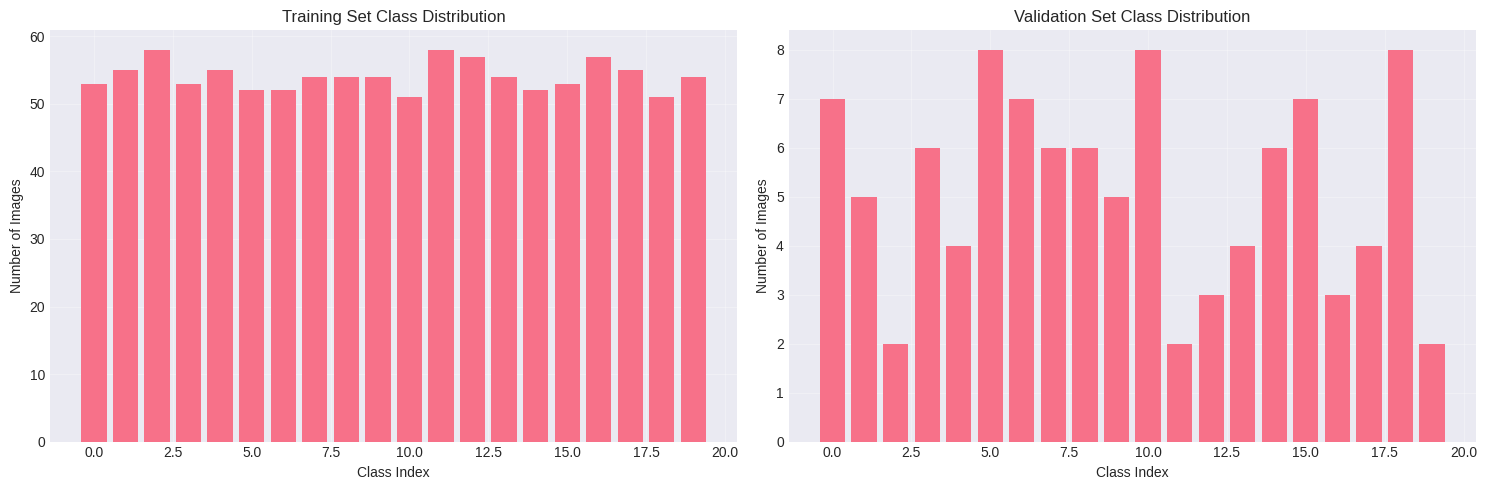


Class distribution statistics:
Train - Min: 51, Max: 58, Mean: 54.1
Val   - Min: 2, Max: 8, Mean: 5.2


In [8]:
# Visualize class distribution
fig, axes = plt.subplots(1, 2, figsize=(15, 5))

# Train distribution
train_class_counts = train_df['class'].value_counts().sort_index()
axes[0].bar(range(len(train_class_counts)), train_class_counts.values)
axes[0].set_xlabel('Class Index')
axes[0].set_ylabel('Number of Images')
axes[0].set_title('Training Set Class Distribution')
axes[0].grid(True, alpha=0.3)

# Val distribution
val_class_counts = val_df['class'].value_counts().sort_index()
axes[1].bar(range(len(val_class_counts)), val_class_counts.values)
axes[1].set_xlabel('Class Index')
axes[1].set_ylabel('Number of Images')
axes[1].set_title('Validation Set Class Distribution')
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig(f'{RESULTS_DIR}/class_distribution.png', dpi=150, bbox_inches='tight')
plt.show()

print(f"\nClass distribution statistics:")
print(f"Train - Min: {train_class_counts.min()}, Max: {train_class_counts.max()}, Mean: {train_class_counts.mean():.1f}")
print(f"Val   - Min: {val_class_counts.min()}, Max: {val_class_counts.max()}, Mean: {val_class_counts.mean():.1f}")

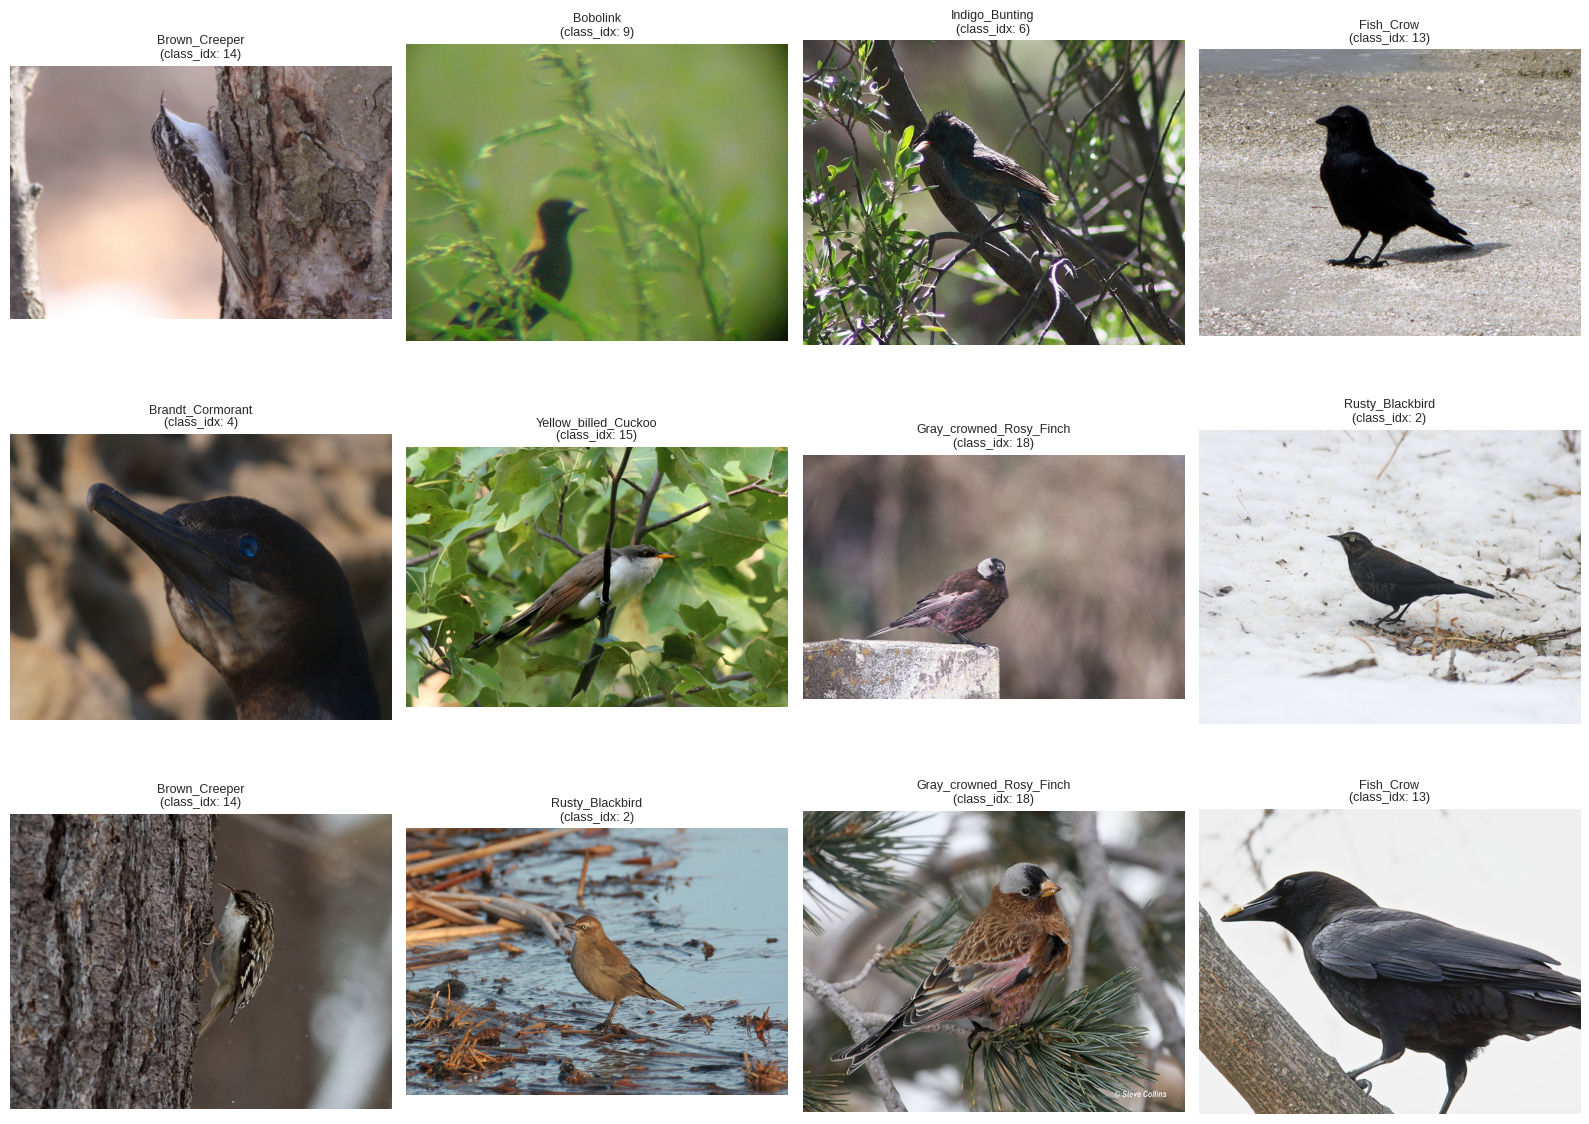

In [9]:
# Visualize sample images
def show_sample_images(df, img_dir, num_samples=12):
    fig, axes = plt.subplots(3, 4, figsize=(16, 12))
    axes = axes.flatten()

    sample_indices = np.random.choice(len(df), num_samples, replace=False)

    for idx, ax in enumerate(axes):
        row = df.iloc[sample_indices[idx]]
        img_path = os.path.join(img_dir, row['path'])

        if os.path.exists(img_path):
            img = Image.open(img_path).convert('RGB')
            ax.imshow(img)
            ax.set_title(f"{row['class']}\n(class_idx: {row['class_idx']})", fontsize=9)
        else:
            ax.text(0.5, 0.5, 'Image not found', ha='center', va='center')

        ax.axis('off')

    plt.tight_layout()
    return fig

fig = show_sample_images(train_df, TRAIN_IMAGES_DIR)
plt.savefig(f'{RESULTS_DIR}/sample_images.png', dpi=150, bbox_inches='tight')
plt.show()

## 5. Data Augmentation and Dataset

Following the paper's approach:
- Random horizontal flipping
- Random vertical flipping  
- Color jittering
- Random affine transformations
- Normalization to [-1, 1] range

In [10]:
# Data augmentation (following paper's approach)
def get_train_transforms(img_size=128):
    return A.Compose([
        A.Resize(img_size, img_size),
        A.HorizontalFlip(p=0.5),
        A.VerticalFlip(p=0.5),
        A.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1, p=0.5),
        A.ShiftScaleRotate(shift_limit=0.1, scale_limit=0.1, rotate_limit=15, p=0.5),
        A.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5]),  # Normalize to [-1, 1]
        ToTensorV2()
    ])

def get_val_transforms(img_size=128):
    return A.Compose([
        A.Resize(img_size, img_size),
        A.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5]),  # Normalize to [-1, 1]
        ToTensorV2()
    ])

print("✓ Data augmentation pipelines created")

✓ Data augmentation pipelines created


In [11]:
# Dataset class
class BirdDataset(Dataset):
    def __init__(self, df, img_dir, transform=None, class_to_idx=None):
        self.df = df.reset_index(drop=True)
        self.img_dir = img_dir
        self.transform = transform
        self.class_to_idx = class_to_idx

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        row = self.df.iloc[idx]
        img_path = os.path.join(self.img_dir, row['path'])

        # Load image
        image = cv2.imread(img_path)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

        # Apply transforms
        if self.transform:
            augmented = self.transform(image=image)
            image = augmented['image']

        # Get label
        if self.class_to_idx:
            label = self.class_to_idx[row['class']]
        else:
            label = row['class_idx']

        return image, label

# Create datasets
train_dataset = BirdDataset(
    train_df,
    TRAIN_IMAGES_DIR,
    transform=get_train_transforms(config.img_size),
    class_to_idx=class_to_idx
)

val_dataset = BirdDataset(
    val_df,
    VAL_IMAGES_DIR,
    transform=get_val_transforms(config.img_size),
    class_to_idx=class_to_idx
)

print(f"✓ Train dataset: {len(train_dataset)} samples")
print(f"✓ Val dataset: {len(val_dataset)} samples")

# Create dataloaders
train_loader = DataLoader(
    train_dataset,
    batch_size=config.batch_size,
    shuffle=True,
    num_workers=config.num_workers,
    pin_memory=True
)

val_loader = DataLoader(
    val_dataset,
    batch_size=config.batch_size,
    shuffle=False,
    num_workers=config.num_workers,
    pin_memory=True
)

print(f"✓ Train batches: {len(train_loader)}")
print(f"✓ Val batches: {len(val_loader)}")

✓ Train dataset: 1082 samples
✓ Val dataset: 103 samples
✓ Train batches: 34
✓ Val batches: 4


## 6. Model Architecture

### 6.1 ArcFace Loss Function
As described in the paper (Equation 2)

In [12]:
# ArcFace Loss implementation (from paper)
class ArcFaceLoss(nn.Module):
    """
    ArcFace Loss as described in the paper:
    L = -1/N * sum(log(e^(s*cos(theta_yi + m)) / (e^(s*cos(theta_yi + m)) + sum(e^(s*cos(theta_j))))))

    Args:
        embedding_size: Dimension of feature embeddings (512 in paper)
        num_classes: Number of classes
        s: Scale factor (default=30.0 in paper)
        m: Angular margin (default=0.5 in paper)
    """
    def __init__(self, embedding_size, num_classes, s=30.0, m=0.5):
        super(ArcFaceLoss, self).__init__()
        self.embedding_size = embedding_size
        self.num_classes = num_classes
        self.s = s
        self.m = m

        # Weight matrix for all classes
        self.weight = nn.Parameter(torch.FloatTensor(num_classes, embedding_size))
        nn.init.xavier_uniform_(self.weight)

        self.cos_m = np.cos(m)
        self.sin_m = np.sin(m)
        self.threshold = np.cos(np.pi - m)
        self.mm = np.sin(np.pi - m) * m

    def forward(self, embeddings, labels):
        # Normalize embeddings and weights
        embeddings = F.normalize(embeddings, p=2, dim=1)
        weight = F.normalize(self.weight, p=2, dim=1)

        # Compute cosine similarity
        cosine = F.linear(embeddings, weight)
        sine = torch.sqrt(1.0 - torch.pow(cosine, 2))

        # cos(theta + m)
        phi = cosine * self.cos_m - sine * self.sin_m
        phi = torch.where(cosine > self.threshold, phi, cosine - self.mm)

        # One-hot encoding
        one_hot = torch.zeros(cosine.size(), device=embeddings.device)
        one_hot.scatter_(1, labels.view(-1, 1).long(), 1)

        # Apply margin to target class
        output = (one_hot * phi) + ((1.0 - one_hot) * cosine)
        output *= self.s

        # Cross entropy loss
        loss = F.cross_entropy(output, labels)

        return loss, output

print("✓ ArcFace loss function defined")

✓ ArcFace loss function defined


### 6.2 ResNet50 Backbone Models

In [13]:
# ResNet50 + ArcFace model
class ResNet50ArcFace(nn.Module):
    """
    ResNet50 with ArcFace loss (as used in the paper)
    - Backbone: ResNet50 pretrained on ImageNet
    - Feature size: 512 dimensions
    - Loss: ArcFace with s=30.0, m=0.5
    """
    def __init__(self, num_classes, embedding_size=512, pretrained=True, s=30.0, m=0.5):
        super(ResNet50ArcFace, self).__init__()

        # Load pretrained ResNet50
        resnet = models.resnet50(pretrained=pretrained)

        # Remove final FC layer
        self.backbone = nn.Sequential(*list(resnet.children())[:-1])

        # Feature embedding layer
        self.fc = nn.Linear(2048, embedding_size)
        self.bn = nn.BatchNorm1d(embedding_size)

        # ArcFace loss
        self.arcface = ArcFaceLoss(embedding_size, num_classes, s=s, m=m)

    def forward(self, x, labels=None):
        # Extract features
        x = self.backbone(x)
        x = x.view(x.size(0), -1)

        # Embedding
        embeddings = self.fc(x)
        embeddings = self.bn(embeddings)

        if labels is not None:
            # Training mode: compute loss
            loss, logits = self.arcface(embeddings, labels)
            return loss, logits, embeddings
        else:
            # Inference mode: return normalized embeddings
            embeddings = F.normalize(embeddings, p=2, dim=1)
            return embeddings

    def get_similarity_scores(self, embeddings):
        """Compute similarity scores with all class prototypes"""
        embeddings = F.normalize(embeddings, p=2, dim=1)
        weight = F.normalize(self.arcface.weight, p=2, dim=1)
        similarity = F.linear(embeddings, weight)
        return similarity


# Standard ResNet50 with Softmax (for comparison)
class ResNet50Softmax(nn.Module):
    """
    Standard ResNet50 with Softmax loss (baseline comparison)
    """
    def __init__(self, num_classes, embedding_size=512, pretrained=True):
        super(ResNet50Softmax, self).__init__()

        # Load pretrained ResNet50
        resnet = models.resnet50(pretrained=pretrained)

        # Remove final FC layer
        self.backbone = nn.Sequential(*list(resnet.children())[:-1])

        # Feature embedding + classification layer
        self.fc1 = nn.Linear(2048, embedding_size)
        self.bn = nn.BatchNorm1d(embedding_size)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(embedding_size, num_classes)

    def forward(self, x, labels=None):
        # Extract features
        x = self.backbone(x)
        x = x.view(x.size(0), -1)

        # Embedding
        embeddings = self.fc1(x)
        embeddings = self.bn(embeddings)
        embeddings = self.relu(embeddings)

        # Classification
        logits = self.fc2(embeddings)

        if labels is not None:
            # Training mode: compute loss
            loss = F.cross_entropy(logits, labels)
            return loss, logits, embeddings
        else:
            # Inference mode
            return logits

print("✓ Model architectures defined")

✓ Model architectures defined


## 7. Training Functions

In [14]:
# Training function
def train_epoch(model, dataloader, optimizer, device, model_type='arcface'):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0

    pbar = tqdm(dataloader, desc='Training')
    for images, labels in pbar:
        images, labels = images.to(device), labels.to(device)

        optimizer.zero_grad()

        # Forward pass
        loss, logits, embeddings = model(images, labels)

        # Backward pass
        loss.backward()
        optimizer.step()

        # Calculate accuracy
        _, predicted = torch.max(logits.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

        running_loss += loss.item()

        pbar.set_postfix({
            'loss': f'{loss.item():.4f}',
            'acc': f'{100.*correct/total:.2f}%'
        })

    epoch_loss = running_loss / len(dataloader)
    epoch_acc = 100. * correct / total

    return epoch_loss, epoch_acc


# Validation function
def validate(model, dataloader, device, model_type='arcface'):
    model.eval()
    running_loss = 0.0
    correct = 0
    total = 0

    all_preds = []
    all_labels = []
    all_probs = []

    with torch.no_grad():
        for images, labels in tqdm(dataloader, desc='Validation'):
            images, labels = images.to(device), labels.to(device)

            # Forward pass
            loss, logits, embeddings = model(images, labels)

            running_loss += loss.item()

            # Get predictions
            if model_type == 'arcface':
                # For ArcFace, logits are similarity scores
                probs = torch.softmax(logits, dim=1)
            else:
                # For Softmax, logits are class scores
                probs = torch.softmax(logits, dim=1)

            _, predicted = torch.max(logits.data, 1)

            total += labels.size(0)
            correct += (predicted == labels).sum().item()

            all_preds.extend(predicted.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
            all_probs.extend(probs.cpu().numpy())

    epoch_loss = running_loss / len(dataloader)
    epoch_acc = 100. * correct / total

    return epoch_loss, epoch_acc, all_preds, all_labels, all_probs

print("✓ Training functions defined")

✓ Training functions defined


In [15]:
# Evaluation metrics (following paper's metrics)
def compute_metrics(all_labels, all_preds, all_probs, model_type='arcface', thresholds=[0.7, 0.8, 0.9, 0.95]):
    """
    Compute metrics as reported in the paper:
    - Top1 accuracy
    - Top5 accuracy
    - Precision, Recall, F1-Score
    - Top1-t accuracy (for ArcFace at different similarity thresholds)
    """
    all_labels = np.array(all_labels)
    all_preds = np.array(all_preds)
    all_probs = np.array(all_probs)

    # Top1 accuracy
    top1_acc = np.mean(all_preds == all_labels)

    # Top5 accuracy
    top5_preds = np.argsort(all_probs, axis=1)[:, -5:]
    top5_acc = np.mean([label in top5_preds[i] for i, label in enumerate(all_labels)])

    # Precision, Recall, F1 (macro average)
    precision, recall, f1, _ = precision_recall_fscore_support(
        all_labels, all_preds, average='macro', zero_division=0
    )

    results = {
        'top1': top1_acc,
        'top5': top5_acc,
        'precision': precision,
        'recall': recall,
        'f1': f1
    }

    # For ArcFace: compute Top1-t accuracy at different thresholds
    if model_type == 'arcface':
        max_probs = np.max(all_probs, axis=1)

        for threshold in thresholds:
            # Samples above threshold
            above_threshold_mask = max_probs >= threshold

            if above_threshold_mask.sum() > 0:
                # Accuracy among samples above threshold
                top1_t = np.mean(
                    all_preds[above_threshold_mask] == all_labels[above_threshold_mask]
                )
                prop_above = above_threshold_mask.mean()
            else:
                top1_t = 0.0
                prop_above = 0.0

            results[f'top1_{threshold}'] = top1_t
            results[f'prop_{threshold}'] = prop_above

    return results

print("✓ Evaluation metrics defined")

✓ Evaluation metrics defined


## 8. Train Models

We'll train both models as in the paper:
1. **ResNet50 + ArcFace** (proposed method)
2. **ResNet50 + Softmax** (baseline)

In [16]:
# Training loop with history tracking
def train_model(model, train_loader, val_loader, optimizer, scheduler,
                num_epochs, device, model_name, model_type='arcface'):

    history = {
        'train_loss': [],
        'train_acc': [],
        'val_loss': [],
        'val_acc': [],
        'val_top5': [],
        'val_precision': [],
        'val_recall': [],
        'val_f1': []
    }

    best_val_acc = 0.0
    best_model_wts = copy.deepcopy(model.state_dict())
    patience_counter = 0

    print(f"\n{'='*70}")
    print(f"Training {model_name}")
    print(f"{'='*70}\n")

    for epoch in range(num_epochs):
        print(f"Epoch {epoch+1}/{num_epochs}")
        print("-" * 50)

        # Train
        train_loss, train_acc = train_epoch(model, train_loader, optimizer, device, model_type)

        # Validate
        val_loss, val_acc, val_preds, val_labels, val_probs = validate(
            model, val_loader, device, model_type
        )

        # Compute metrics
        metrics = compute_metrics(val_labels, val_preds, val_probs, model_type)

        # Update history
        history['train_loss'].append(train_loss)
        history['train_acc'].append(train_acc)
        history['val_loss'].append(val_loss)
        history['val_acc'].append(val_acc)
        history['val_top5'].append(metrics['top5'])
        history['val_precision'].append(metrics['precision'])
        history['val_recall'].append(metrics['recall'])
        history['val_f1'].append(metrics['f1'])

        # Learning rate scheduler
        scheduler.step()

        # Print epoch summary
        print(f"\nEpoch Summary:")
        print(f"  Train Loss: {train_loss:.4f} | Train Acc: {train_acc:.2f}%")
        print(f"  Val Loss: {val_loss:.4f} | Val Acc: {val_acc:.2f}%")
        print(f"  Top5: {metrics['top5']*100:.2f}% | F1: {metrics['f1']:.4f}")

        if model_type == 'arcface':
            print(f"  Top1-0.8: {metrics.get('top1_0.8', 0)*100:.2f}% | "
                  f"Prop>0.8: {metrics.get('prop_0.8', 0)*100:.2f}%")

        # Save best model
        if val_acc > best_val_acc:
            best_val_acc = val_acc
            best_model_wts = copy.deepcopy(model.state_dict())
            patience_counter = 0

            # Save checkpoint
            torch.save({
                'epoch': epoch,
                'model_state_dict': model.state_dict(),
                'optimizer_state_dict': optimizer.state_dict(),
                'val_acc': val_acc,
                'history': history
            }, f'{CHECKPOINT_DIR}/{model_name}_best.pth')

            print(f"  ✓ New best model saved (Val Acc: {val_acc:.2f}%)")
        else:
            patience_counter += 1

        # Early stopping
        if patience_counter >= config.patience:
            print(f"\nEarly stopping triggered after {epoch+1} epochs")
            break

        print()

    # Load best model weights
    model.load_state_dict(best_model_wts)

    print(f"\nTraining completed! Best Val Acc: {best_val_acc:.2f}%")

    return model, history

print("✓ Training loop defined")

✓ Training loop defined


### 8.1 Train ResNet50 + ArcFace

In [17]:
# Initialize ResNet50 + ArcFace model
model_arcface = ResNet50ArcFace(
    num_classes=num_classes,
    embedding_size=config.embedding_size,
    pretrained=config.pretrained,
    s=config.arcface_s,
    m=config.arcface_m
).to(config.device)

# Optimizer (SGD as in paper)
optimizer_arcface = SGD(
    model_arcface.parameters(),
    lr=config.learning_rate,
    momentum=config.momentum,
    weight_decay=config.weight_decay
)

# Learning rate scheduler
scheduler_arcface = StepLR(optimizer_arcface, step_size=30, gamma=0.1)

print(f"Model parameters: {sum(p.numel() for p in model_arcface.parameters()):,}")
print(f"Trainable parameters: {sum(p.numel() for p in model_arcface.parameters() if p.requires_grad):,}")

Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth


100%|██████████| 97.8M/97.8M [00:00<00:00, 199MB/s]


Model parameters: 24,568,384
Trainable parameters: 24,568,384


In [18]:
# Train ResNet50 + ArcFace
model_arcface, history_arcface = train_model(
    model_arcface,
    train_loader,
    val_loader,
    optimizer_arcface,
    scheduler_arcface,
    config.num_epochs,
    config.device,
    'ResNet50_ArcFace',
    model_type='arcface'
)


Training ResNet50_ArcFace

Epoch 1/100
--------------------------------------------------


Training:   0%|          | 0/34 [00:00<?, ?it/s]

Validation:   0%|          | 0/4 [00:00<?, ?it/s]


Epoch Summary:
  Train Loss: 15.6828 | Train Acc: 1.39%
  Val Loss: 11.0629 | Val Acc: 9.71%
  Top5: 19.42% | F1: 0.0854
  Top1-0.8: 12.50% | Prop>0.8: 46.60%
  ✓ New best model saved (Val Acc: 9.71%)

Epoch 2/100
--------------------------------------------------


Training:   0%|          | 0/34 [00:00<?, ?it/s]

Validation:   0%|          | 0/4 [00:00<?, ?it/s]


Epoch Summary:
  Train Loss: 11.4642 | Train Acc: 22.00%
  Val Loss: 10.6018 | Val Acc: 17.48%
  Top5: 39.81% | F1: 0.1321
  Top1-0.8: 22.39% | Prop>0.8: 65.05%
  ✓ New best model saved (Val Acc: 17.48%)

Epoch 3/100
--------------------------------------------------


Training:   0%|          | 0/34 [00:00<?, ?it/s]

Validation:   0%|          | 0/4 [00:00<?, ?it/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7dc40af21580>
Traceback (most recent call last):
Exception ignored in:   File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1654, in __del__
<function _MultiProcessingDataLoaderIter.__del__ at 0x7dc40af21580>
    Traceback (most recent call last):
self._shutdown_workers()  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1654, in __del__

  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1637, in _shutdown_workers
        if w.is_alive():self._shutdown_workers()

   File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1637, in _shutdown_workers
      if w.is_alive():  
   ^  ^  ^^ ^ ^^^^^^^^^^^^^^^
  File "/usr/lib/python3.12/multiprocessing/process.py", line 160, in is_alive
^^    ^assert self._parent_pid == os.getpid(), 'can only test a child process'^

  File "/usr/lib/python


Epoch Summary:
  Train Loss: 10.5027 | Train Acc: 30.59%
  Val Loss: 9.9391 | Val Acc: 31.07%
  Top5: 47.57% | F1: 0.3036
  Top1-0.8: 37.14% | Prop>0.8: 67.96%
  ✓ New best model saved (Val Acc: 31.07%)

Epoch 4/100
--------------------------------------------------


Training:   0%|          | 0/34 [00:00<?, ?it/s]

Validation:   0%|          | 0/4 [00:00<?, ?it/s]


Epoch Summary:
  Train Loss: 8.6561 | Train Acc: 39.56%
  Val Loss: 11.0529 | Val Acc: 33.01%
  Top5: 42.72% | F1: 0.2623
  Top1-0.8: 38.55% | Prop>0.8: 80.58%
  ✓ New best model saved (Val Acc: 33.01%)

Epoch 5/100
--------------------------------------------------


Training:   0%|          | 0/34 [00:00<?, ?it/s]

Validation:   0%|          | 0/4 [00:00<?, ?it/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7dc40af21580>
Traceback (most recent call last):
Exception ignored in:   File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1654, in __del__
<function _MultiProcessingDataLoaderIter.__del__ at 0x7dc40af21580>    
self._shutdown_workers()
Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1637, in _shutdown_workers
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1654, in __del__
        if w.is_alive():self._shutdown_workers()

   File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1637, in _shutdown_workers
      if w.is_alive(): 
      ^^^^ ^ ^ ^ ^^^^^^^^^
^  File "/usr/lib/python3.12/multiprocessing/process.py", line 160, in is_alive
^    ^assert self._parent_pid == os.getpid(), 'can only test a child process'^
^ ^ ^ ^ 
   File "/usr/lib/p


Epoch Summary:
  Train Loss: 8.6290 | Train Acc: 43.16%
  Val Loss: 8.4937 | Val Acc: 44.66%
  Top5: 55.34% | F1: 0.4069
  Top1-0.8: 50.00% | Prop>0.8: 81.55%
  ✓ New best model saved (Val Acc: 44.66%)

Epoch 6/100
--------------------------------------------------


Training:   0%|          | 0/34 [00:00<?, ?it/s]

Validation:   0%|          | 0/4 [00:00<?, ?it/s]


Epoch Summary:
  Train Loss: 7.8856 | Train Acc: 46.58%
  Val Loss: 11.8121 | Val Acc: 38.83%
  Top5: 50.49% | F1: 0.3764
  Top1-0.8: 39.77% | Prop>0.8: 85.44%

Epoch 7/100
--------------------------------------------------


Training:   0%|          | 0/34 [00:00<?, ?it/s]

Validation:   0%|          | 0/4 [00:00<?, ?it/s]


Epoch Summary:
  Train Loss: 7.3890 | Train Acc: 48.98%
  Val Loss: 9.9730 | Val Acc: 43.69%
  Top5: 52.43% | F1: 0.3986
  Top1-0.8: 48.35% | Prop>0.8: 88.35%

Epoch 8/100
--------------------------------------------------


Training:   0%|          | 0/34 [00:00<?, ?it/s]

Validation:   0%|          | 0/4 [00:00<?, ?it/s]


Epoch Summary:
  Train Loss: 6.8375 | Train Acc: 52.59%
  Val Loss: 8.1828 | Val Acc: 46.60%
  Top5: 59.22% | F1: 0.4113
  Top1-0.8: 53.41% | Prop>0.8: 85.44%
  ✓ New best model saved (Val Acc: 46.60%)

Epoch 9/100
--------------------------------------------------


Training:   0%|          | 0/34 [00:00<?, ?it/s]

Validation:   0%|          | 0/4 [00:00<?, ?it/s]


Epoch Summary:
  Train Loss: 6.7053 | Train Acc: 52.77%
  Val Loss: 9.5867 | Val Acc: 40.78%
  Top5: 60.19% | F1: 0.3703
  Top1-0.8: 42.86% | Prop>0.8: 88.35%

Epoch 10/100
--------------------------------------------------


Training:   0%|          | 0/34 [00:00<?, ?it/s]

Validation:   0%|          | 0/4 [00:00<?, ?it/s]


Epoch Summary:
  Train Loss: 5.9618 | Train Acc: 58.23%
  Val Loss: 13.1421 | Val Acc: 39.81%
  Top5: 57.28% | F1: 0.3941
  Top1-0.8: 44.09% | Prop>0.8: 90.29%

Epoch 11/100
--------------------------------------------------


Training:   0%|          | 0/34 [00:00<?, ?it/s]

Validation:   0%|          | 0/4 [00:00<?, ?it/s]


Epoch Summary:
  Train Loss: 5.5628 | Train Acc: 59.24%
  Val Loss: 10.9930 | Val Acc: 41.75%
  Top5: 56.31% | F1: 0.4014
  Top1-0.8: 47.67% | Prop>0.8: 83.50%

Epoch 12/100
--------------------------------------------------


Training:   0%|          | 0/34 [00:00<?, ?it/s]

Validation:   0%|          | 0/4 [00:00<?, ?it/s]


Epoch Summary:
  Train Loss: 5.5787 | Train Acc: 59.52%
  Val Loss: 7.7860 | Val Acc: 46.60%
  Top5: 64.08% | F1: 0.4480
  Top1-0.8: 50.55% | Prop>0.8: 88.35%

Epoch 13/100
--------------------------------------------------


Training:   0%|          | 0/34 [00:00<?, ?it/s]

Validation:   0%|          | 0/4 [00:00<?, ?it/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7dc40af21580>
Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1654, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1637, in _shutdown_workers
    if w.is_alive():
       ^^^^^^^^^^^^
  File "/usr/lib/python3.12/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7dc40af21580>
Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1654, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 16


Epoch Summary:
  Train Loss: 4.8891 | Train Acc: 63.68%
  Val Loss: 11.5844 | Val Acc: 38.83%
  Top5: 62.14% | F1: 0.3875
  Top1-0.8: 39.13% | Prop>0.8: 89.32%

Epoch 14/100
--------------------------------------------------


Training:   0%|          | 0/34 [00:00<?, ?it/s]

Validation:   0%|          | 0/4 [00:00<?, ?it/s]


Epoch Summary:
  Train Loss: 4.8697 | Train Acc: 63.68%
  Val Loss: 11.2275 | Val Acc: 43.69%
  Top5: 59.22% | F1: 0.4123
  Top1-0.8: 46.32% | Prop>0.8: 92.23%

Epoch 15/100
--------------------------------------------------


Training:   0%|          | 0/34 [00:00<?, ?it/s]

Validation:   0%|          | 0/4 [00:00<?, ?it/s]


Epoch Summary:
  Train Loss: 4.4333 | Train Acc: 68.02%
  Val Loss: 8.2087 | Val Acc: 47.57%
  Top5: 65.05% | F1: 0.4554
  Top1-0.8: 51.65% | Prop>0.8: 88.35%
  ✓ New best model saved (Val Acc: 47.57%)

Epoch 16/100
--------------------------------------------------


Training:   0%|          | 0/34 [00:00<?, ?it/s]

Validation:   0%|          | 0/4 [00:00<?, ?it/s]


Epoch Summary:
  Train Loss: 3.9163 | Train Acc: 70.15%
  Val Loss: 8.8844 | Val Acc: 50.49%
  Top5: 66.02% | F1: 0.4538
  Top1-0.8: 55.43% | Prop>0.8: 89.32%
  ✓ New best model saved (Val Acc: 50.49%)

Epoch 17/100
--------------------------------------------------


Training:   0%|          | 0/34 [00:00<?, ?it/s]

Validation:   0%|          | 0/4 [00:00<?, ?it/s]


Epoch Summary:
  Train Loss: 3.7299 | Train Acc: 70.52%
  Val Loss: 8.8194 | Val Acc: 49.51%
  Top5: 63.11% | F1: 0.4707
  Top1-0.8: 52.22% | Prop>0.8: 87.38%

Epoch 18/100
--------------------------------------------------


Training:   0%|          | 0/34 [00:00<?, ?it/s]

Validation:   0%|          | 0/4 [00:00<?, ?it/s]


Epoch Summary:
  Train Loss: 3.2606 | Train Acc: 73.20%
  Val Loss: 8.5171 | Val Acc: 49.51%
  Top5: 66.02% | F1: 0.4846
  Top1-0.8: 52.69% | Prop>0.8: 90.29%

Epoch 19/100
--------------------------------------------------


Training:   0%|          | 0/34 [00:00<?, ?it/s]

Validation:   0%|          | 0/4 [00:00<?, ?it/s]


Epoch Summary:
  Train Loss: 3.1685 | Train Acc: 74.21%
  Val Loss: 9.4675 | Val Acc: 48.54%
  Top5: 62.14% | F1: 0.4417
  Top1-0.8: 52.27% | Prop>0.8: 85.44%

Epoch 20/100
--------------------------------------------------


Training:   0%|          | 0/34 [00:00<?, ?it/s]

Validation:   0%|          | 0/4 [00:00<?, ?it/s]


Epoch Summary:
  Train Loss: 3.2008 | Train Acc: 75.05%
  Val Loss: 10.1869 | Val Acc: 43.69%
  Top5: 59.22% | F1: 0.4172
  Top1-0.8: 46.32% | Prop>0.8: 92.23%

Epoch 21/100
--------------------------------------------------


Training:   0%|          | 0/34 [00:00<?, ?it/s]

Validation:   0%|          | 0/4 [00:00<?, ?it/s]


Epoch Summary:
  Train Loss: 3.1894 | Train Acc: 74.86%
  Val Loss: 8.3558 | Val Acc: 49.51%
  Top5: 65.05% | F1: 0.4688
  Top1-0.8: 51.61% | Prop>0.8: 90.29%

Epoch 22/100
--------------------------------------------------


Training:   0%|          | 0/34 [00:00<?, ?it/s]

Validation:   0%|          | 0/4 [00:00<?, ?it/s]


Epoch Summary:
  Train Loss: 2.9862 | Train Acc: 74.95%
  Val Loss: 8.3316 | Val Acc: 52.43%
  Top5: 68.93% | F1: 0.4864
  Top1-0.8: 55.56% | Prop>0.8: 87.38%
  ✓ New best model saved (Val Acc: 52.43%)

Epoch 23/100
--------------------------------------------------


Training:   0%|          | 0/34 [00:00<?, ?it/s]

Validation:   0%|          | 0/4 [00:00<?, ?it/s]


Epoch Summary:
  Train Loss: 2.6541 | Train Acc: 76.52%
  Val Loss: 9.7494 | Val Acc: 46.60%
  Top5: 65.05% | F1: 0.4497
  Top1-0.8: 47.37% | Prop>0.8: 92.23%

Epoch 24/100
--------------------------------------------------


Training:   0%|          | 0/34 [00:00<?, ?it/s]

Validation:   0%|          | 0/4 [00:00<?, ?it/s]


Epoch Summary:
  Train Loss: 2.6079 | Train Acc: 77.26%
  Val Loss: 7.8515 | Val Acc: 52.43%
  Top5: 73.79% | F1: 0.4884
  Top1-0.8: 53.12% | Prop>0.8: 93.20%

Epoch 25/100
--------------------------------------------------


Training:   0%|          | 0/34 [00:00<?, ?it/s]

Validation:   0%|          | 0/4 [00:00<?, ?it/s]


Epoch Summary:
  Train Loss: 2.3154 | Train Acc: 79.48%
  Val Loss: 8.7146 | Val Acc: 51.46%
  Top5: 66.02% | F1: 0.4921
  Top1-0.8: 52.63% | Prop>0.8: 92.23%

Epoch 26/100
--------------------------------------------------


Training:   0%|          | 0/34 [00:00<?, ?it/s]

Validation:   0%|          | 0/4 [00:00<?, ?it/s]


Epoch Summary:
  Train Loss: 2.1001 | Train Acc: 80.87%
  Val Loss: 7.9757 | Val Acc: 55.34%
  Top5: 67.96% | F1: 0.5256
  Top1-0.8: 60.44% | Prop>0.8: 88.35%
  ✓ New best model saved (Val Acc: 55.34%)

Epoch 27/100
--------------------------------------------------


Training:   0%|          | 0/34 [00:00<?, ?it/s]

Validation:   0%|          | 0/4 [00:00<?, ?it/s]


Epoch Summary:
  Train Loss: 2.3850 | Train Acc: 80.13%
  Val Loss: 7.8440 | Val Acc: 56.31%
  Top5: 71.84% | F1: 0.5149
  Top1-0.8: 61.54% | Prop>0.8: 88.35%
  ✓ New best model saved (Val Acc: 56.31%)

Epoch 28/100
--------------------------------------------------


Training:   0%|          | 0/34 [00:00<?, ?it/s]

Validation:   0%|          | 0/4 [00:00<?, ?it/s]


Epoch Summary:
  Train Loss: 2.2971 | Train Acc: 81.05%
  Val Loss: 8.2472 | Val Acc: 61.17%
  Top5: 66.99% | F1: 0.5613
  Top1-0.8: 64.89% | Prop>0.8: 91.26%
  ✓ New best model saved (Val Acc: 61.17%)

Epoch 29/100
--------------------------------------------------


Training:   0%|          | 0/34 [00:00<?, ?it/s]

Validation:   0%|          | 0/4 [00:00<?, ?it/s]


Epoch Summary:
  Train Loss: 1.9679 | Train Acc: 82.90%
  Val Loss: 8.1691 | Val Acc: 52.43%
  Top5: 70.87% | F1: 0.5015
  Top1-0.8: 52.08% | Prop>0.8: 93.20%

Epoch 30/100
--------------------------------------------------


Training:   0%|          | 0/34 [00:00<?, ?it/s]

Validation:   0%|          | 0/4 [00:00<?, ?it/s]


Epoch Summary:
  Train Loss: 1.9785 | Train Acc: 81.98%
  Val Loss: 9.4072 | Val Acc: 52.43%
  Top5: 60.19% | F1: 0.5027
  Top1-0.8: 58.06% | Prop>0.8: 90.29%

Epoch 31/100
--------------------------------------------------


Training:   0%|          | 0/34 [00:00<?, ?it/s]

Validation:   0%|          | 0/4 [00:00<?, ?it/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7dc40af21580>
Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1654, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1637, in _shutdown_workers
    if w.is_alive():
       ^^^^^^^^^^^^
  File "/usr/lib/python3.12/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7dc40af21580>
Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1654, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 16


Epoch Summary:
  Train Loss: 1.5111 | Train Acc: 85.30%
  Val Loss: 8.6259 | Val Acc: 54.37%
  Top5: 68.93% | F1: 0.5227
  Top1-0.8: 56.70% | Prop>0.8: 94.17%

Epoch 32/100
--------------------------------------------------


Training:   0%|          | 0/34 [00:00<?, ?it/s]

Validation:   0%|          | 0/4 [00:00<?, ?it/s]


Epoch Summary:
  Train Loss: 1.0319 | Train Acc: 88.26%
  Val Loss: 8.2428 | Val Acc: 55.34%
  Top5: 68.93% | F1: 0.5290
  Top1-0.8: 58.16% | Prop>0.8: 95.15%

Epoch 33/100
--------------------------------------------------


Training:   0%|          | 0/34 [00:00<?, ?it/s]

Validation:   0%|          | 0/4 [00:00<?, ?it/s]


Epoch Summary:
  Train Loss: 1.1367 | Train Acc: 88.91%
  Val Loss: 7.9805 | Val Acc: 56.31%
  Top5: 70.87% | F1: 0.5430
  Top1-0.8: 57.58% | Prop>0.8: 96.12%

Epoch 34/100
--------------------------------------------------


Training:   0%|          | 0/34 [00:00<?, ?it/s]

Validation:   0%|          | 0/4 [00:00<?, ?it/s]


Epoch Summary:
  Train Loss: 0.8607 | Train Acc: 90.11%
  Val Loss: 7.6832 | Val Acc: 57.28%
  Top5: 70.87% | F1: 0.5530
  Top1-0.8: 60.64% | Prop>0.8: 91.26%

Epoch 35/100
--------------------------------------------------


Training:   0%|          | 0/34 [00:00<?, ?it/s]

Validation:   0%|          | 0/4 [00:00<?, ?it/s]


Epoch Summary:
  Train Loss: 0.7876 | Train Acc: 91.31%
  Val Loss: 7.4987 | Val Acc: 59.22%
  Top5: 69.90% | F1: 0.5916
  Top1-0.8: 62.77% | Prop>0.8: 91.26%

Epoch 36/100
--------------------------------------------------


Training:   0%|          | 0/34 [00:00<?, ?it/s]

Validation:   0%|          | 0/4 [00:00<?, ?it/s]


Epoch Summary:
  Train Loss: 0.8491 | Train Acc: 90.20%
  Val Loss: 7.6558 | Val Acc: 59.22%
  Top5: 68.93% | F1: 0.5694
  Top1-0.8: 63.74% | Prop>0.8: 88.35%

Epoch 37/100
--------------------------------------------------


Training:   0%|          | 0/34 [00:00<?, ?it/s]

Validation:   0%|          | 0/4 [00:00<?, ?it/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7dc40af21580>
Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1654, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1637, in _shutdown_workers
    if w.is_alive():
       ^^^^^^^^^^^^
  File "/usr/lib/python3.12/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7dc40af21580>
Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1654, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 16


Epoch Summary:
  Train Loss: 0.6184 | Train Acc: 93.25%
  Val Loss: 7.4807 | Val Acc: 61.17%
  Top5: 68.93% | F1: 0.5966
  Top1-0.8: 63.92% | Prop>0.8: 94.17%

Epoch 38/100
--------------------------------------------------


Training:   0%|          | 0/34 [00:00<?, ?it/s]

Validation:   0%|          | 0/4 [00:00<?, ?it/s]


Epoch Summary:
  Train Loss: 0.4310 | Train Acc: 94.64%
  Val Loss: 7.5573 | Val Acc: 59.22%
  Top5: 69.90% | F1: 0.5861
  Top1-0.8: 61.70% | Prop>0.8: 91.26%

Epoch 39/100
--------------------------------------------------


Training:   0%|          | 0/34 [00:00<?, ?it/s]

Validation:   0%|          | 0/4 [00:00<?, ?it/s]


Epoch Summary:
  Train Loss: 0.5926 | Train Acc: 92.88%
  Val Loss: 7.5677 | Val Acc: 59.22%
  Top5: 68.93% | F1: 0.5618
  Top1-0.8: 61.46% | Prop>0.8: 93.20%

Epoch 40/100
--------------------------------------------------


Training:   0%|          | 0/34 [00:00<?, ?it/s]

Validation:   0%|          | 0/4 [00:00<?, ?it/s]


Epoch Summary:
  Train Loss: 0.5127 | Train Acc: 93.72%
  Val Loss: 7.5159 | Val Acc: 60.19%
  Top5: 70.87% | F1: 0.5940
  Top1-0.8: 63.54% | Prop>0.8: 93.20%

Epoch 41/100
--------------------------------------------------


Training:   0%|          | 0/34 [00:00<?, ?it/s]

Validation:   0%|          | 0/4 [00:00<?, ?it/s]


Epoch Summary:
  Train Loss: 0.6101 | Train Acc: 93.16%
  Val Loss: 7.5602 | Val Acc: 58.25%
  Top5: 68.93% | F1: 0.5819
  Top1-0.8: 62.64% | Prop>0.8: 88.35%

Epoch 42/100
--------------------------------------------------


Training:   0%|          | 0/34 [00:00<?, ?it/s]

Validation:   0%|          | 0/4 [00:00<?, ?it/s]


Epoch Summary:
  Train Loss: 0.6515 | Train Acc: 92.61%
  Val Loss: 7.6224 | Val Acc: 57.28%
  Top5: 69.90% | F1: 0.5731
  Top1-0.8: 61.05% | Prop>0.8: 92.23%

Epoch 43/100
--------------------------------------------------


Training:   0%|          | 0/34 [00:00<?, ?it/s]

Validation:   0%|          | 0/4 [00:00<?, ?it/s]


Epoch Summary:
  Train Loss: 0.3842 | Train Acc: 95.19%
  Val Loss: 7.5587 | Val Acc: 59.22%
  Top5: 69.90% | F1: 0.5883
  Top1-0.8: 62.89% | Prop>0.8: 94.17%

Early stopping triggered after 43 epochs

Training completed! Best Val Acc: 61.17%


### 8.2 Train ResNet50 + Softmax (Baseline)

In [19]:
# Initialize ResNet50 + Softmax model
model_softmax = ResNet50Softmax(
    num_classes=num_classes,
    embedding_size=config.embedding_size,
    pretrained=config.pretrained
).to(config.device)

# Optimizer
optimizer_softmax = SGD(
    model_softmax.parameters(),
    lr=config.learning_rate,
    momentum=config.momentum,
    weight_decay=config.weight_decay
)

# Learning rate scheduler
scheduler_softmax = StepLR(optimizer_softmax, step_size=30, gamma=0.1)

print(f"Model parameters: {sum(p.numel() for p in model_softmax.parameters()):,}")
print(f"Trainable parameters: {sum(p.numel() for p in model_softmax.parameters() if p.requires_grad):,}")

Model parameters: 24,568,404
Trainable parameters: 24,568,404


In [20]:
# Train ResNet50 + Softmax
model_softmax, history_softmax = train_model(
    model_softmax,
    train_loader,
    val_loader,
    optimizer_softmax,
    scheduler_softmax,
    config.num_epochs,
    config.device,
    'ResNet50_Softmax',
    model_type='softmax'
)


Training ResNet50_Softmax

Epoch 1/100
--------------------------------------------------


Training:   0%|          | 0/34 [00:00<?, ?it/s]

Validation:   0%|          | 0/4 [00:00<?, ?it/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7dc40af21580>
Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1654, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1637, in _shutdown_workers
    if w.is_alive():
       ^^^^^^^^^^^^
  File "/usr/lib/python3.12/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
AssertionError: can only test a child process



Epoch Summary:
  Train Loss: 2.8174 | Train Acc: 16.64%
  Val Loss: 2.2133 | Val Acc: 48.54%
  Top5: 84.47% | F1: 0.4485
  ✓ New best model saved (Val Acc: 48.54%)

Epoch 2/100
--------------------------------------------------


Training:   0%|          | 0/34 [00:00<?, ?it/s]

Validation:   0%|          | 0/4 [00:00<?, ?it/s]


Epoch Summary:
  Train Loss: 1.9567 | Train Acc: 51.85%
  Val Loss: 1.2534 | Val Acc: 62.14%
  Top5: 93.20% | F1: 0.5689
  ✓ New best model saved (Val Acc: 62.14%)

Epoch 3/100
--------------------------------------------------


Training:   0%|          | 0/34 [00:00<?, ?it/s]

Validation:   0%|          | 0/4 [00:00<?, ?it/s]


Epoch Summary:
  Train Loss: 1.3442 | Train Acc: 67.28%
  Val Loss: 0.9700 | Val Acc: 64.08%
  Top5: 95.15% | F1: 0.6174
  ✓ New best model saved (Val Acc: 64.08%)

Epoch 4/100
--------------------------------------------------


Training:   0%|          | 0/34 [00:00<?, ?it/s]

Validation:   0%|          | 0/4 [00:00<?, ?it/s]


Epoch Summary:
  Train Loss: 1.0339 | Train Acc: 73.57%
  Val Loss: 0.8258 | Val Acc: 70.87%
  Top5: 98.06% | F1: 0.6636
  ✓ New best model saved (Val Acc: 70.87%)

Epoch 5/100
--------------------------------------------------


Training:   0%|          | 0/34 [00:00<?, ?it/s]

Validation:   0%|          | 0/4 [00:00<?, ?it/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7dc40af21580>
Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1654, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1637, in _shutdown_workers
    if w.is_alive():
       ^^^^^^^^^^^^
  File "/usr/lib/python3.12/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7dc40af21580>
Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1654, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 16


Epoch Summary:
  Train Loss: 0.8373 | Train Acc: 78.37%
  Val Loss: 0.8157 | Val Acc: 71.84%
  Top5: 98.06% | F1: 0.7076
  ✓ New best model saved (Val Acc: 71.84%)

Epoch 6/100
--------------------------------------------------


Training:   0%|          | 0/34 [00:00<?, ?it/s]

Validation:   0%|          | 0/4 [00:00<?, ?it/s]


Epoch Summary:
  Train Loss: 0.7239 | Train Acc: 79.48%
  Val Loss: 0.7470 | Val Acc: 71.84%
  Top5: 98.06% | F1: 0.6933

Epoch 7/100
--------------------------------------------------


Training:   0%|          | 0/34 [00:00<?, ?it/s]

Validation:   0%|          | 0/4 [00:00<?, ?it/s]


Epoch Summary:
  Train Loss: 0.6144 | Train Acc: 83.64%
  Val Loss: 0.6507 | Val Acc: 77.67%
  Top5: 97.09% | F1: 0.7578
  ✓ New best model saved (Val Acc: 77.67%)

Epoch 8/100
--------------------------------------------------


Training:   0%|          | 0/34 [00:00<?, ?it/s]

Validation:   0%|          | 0/4 [00:00<?, ?it/s]


Epoch Summary:
  Train Loss: 0.5146 | Train Acc: 86.04%
  Val Loss: 0.6622 | Val Acc: 75.73%
  Top5: 98.06% | F1: 0.7349

Epoch 9/100
--------------------------------------------------


Training:   0%|          | 0/34 [00:00<?, ?it/s]

Validation:   0%|          | 0/4 [00:00<?, ?it/s]


Epoch Summary:
  Train Loss: 0.4580 | Train Acc: 87.43%
  Val Loss: 0.6445 | Val Acc: 76.70%
  Top5: 96.12% | F1: 0.7626

Epoch 10/100
--------------------------------------------------


Training:   0%|          | 0/34 [00:00<?, ?it/s]

Validation:   0%|          | 0/4 [00:00<?, ?it/s]


Epoch Summary:
  Train Loss: 0.3521 | Train Acc: 91.87%
  Val Loss: 0.5704 | Val Acc: 76.70%
  Top5: 97.09% | F1: 0.7327

Epoch 11/100
--------------------------------------------------


Training:   0%|          | 0/34 [00:00<?, ?it/s]

Validation:   0%|          | 0/4 [00:00<?, ?it/s]


Epoch Summary:
  Train Loss: 0.3423 | Train Acc: 90.67%
  Val Loss: 0.5951 | Val Acc: 78.64%
  Top5: 98.06% | F1: 0.7673
  ✓ New best model saved (Val Acc: 78.64%)

Epoch 12/100
--------------------------------------------------


Training:   0%|          | 0/34 [00:00<?, ?it/s]

Validation:   0%|          | 0/4 [00:00<?, ?it/s]


Epoch Summary:
  Train Loss: 0.2978 | Train Acc: 93.62%
  Val Loss: 0.6247 | Val Acc: 79.61%
  Top5: 98.06% | F1: 0.7806
  ✓ New best model saved (Val Acc: 79.61%)

Epoch 13/100
--------------------------------------------------


Training:   0%|          | 0/34 [00:00<?, ?it/s]

Validation:   0%|          | 0/4 [00:00<?, ?it/s]


Epoch Summary:
  Train Loss: 0.2615 | Train Acc: 93.44%
  Val Loss: 0.5751 | Val Acc: 80.58%
  Top5: 98.06% | F1: 0.7841
  ✓ New best model saved (Val Acc: 80.58%)

Epoch 14/100
--------------------------------------------------


Training:   0%|          | 0/34 [00:00<?, ?it/s]

Validation:   0%|          | 0/4 [00:00<?, ?it/s]


Epoch Summary:
  Train Loss: 0.2332 | Train Acc: 94.55%
  Val Loss: 0.6484 | Val Acc: 76.70%
  Top5: 97.09% | F1: 0.7439

Epoch 15/100
--------------------------------------------------


Training:   0%|          | 0/34 [00:00<?, ?it/s]

Validation:   0%|          | 0/4 [00:00<?, ?it/s]


Epoch Summary:
  Train Loss: 0.2216 | Train Acc: 94.73%
  Val Loss: 0.6257 | Val Acc: 74.76%
  Top5: 97.09% | F1: 0.7253

Epoch 16/100
--------------------------------------------------


Training:   0%|          | 0/34 [00:00<?, ?it/s]

Validation:   0%|          | 0/4 [00:00<?, ?it/s]


Epoch Summary:
  Train Loss: 0.2562 | Train Acc: 92.79%
  Val Loss: 0.6166 | Val Acc: 71.84%
  Top5: 97.09% | F1: 0.7004

Epoch 17/100
--------------------------------------------------


Training:   0%|          | 0/34 [00:00<?, ?it/s]

Validation:   0%|          | 0/4 [00:00<?, ?it/s]


Epoch Summary:
  Train Loss: 0.1790 | Train Acc: 95.93%
  Val Loss: 0.6221 | Val Acc: 76.70%
  Top5: 98.06% | F1: 0.7437

Epoch 18/100
--------------------------------------------------


Training:   0%|          | 0/34 [00:00<?, ?it/s]

Validation:   0%|          | 0/4 [00:00<?, ?it/s]


Epoch Summary:
  Train Loss: 0.1829 | Train Acc: 96.21%
  Val Loss: 0.6719 | Val Acc: 76.70%
  Top5: 99.03% | F1: 0.7440

Epoch 19/100
--------------------------------------------------


Training:   0%|          | 0/34 [00:00<?, ?it/s]

Validation:   0%|          | 0/4 [00:00<?, ?it/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7dc40af21580>
Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1654, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1637, in _shutdown_workers
    if w.is_alive():
       ^^^^^^^^^^^^
  File "/usr/lib/python3.12/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7dc40af21580>
Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1654, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 16


Epoch Summary:
  Train Loss: 0.1407 | Train Acc: 97.23%
  Val Loss: 0.5995 | Val Acc: 78.64%
  Top5: 98.06% | F1: 0.7626

Epoch 20/100
--------------------------------------------------


Training:   0%|          | 0/34 [00:00<?, ?it/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7dc40af21580>
Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1654, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1637, in _shutdown_workers
    if w.is_alive():
       ^^^^^^^^^^^^
  File "/usr/lib/python3.12/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7dc40af21580>
Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1654, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 16

Validation:   0%|          | 0/4 [00:00<?, ?it/s]


Epoch Summary:
  Train Loss: 0.1505 | Train Acc: 97.13%
  Val Loss: 0.6198 | Val Acc: 76.70%
  Top5: 96.12% | F1: 0.7570

Epoch 21/100
--------------------------------------------------


Training:   0%|          | 0/34 [00:00<?, ?it/s]

Validation:   0%|          | 0/4 [00:00<?, ?it/s]


Epoch Summary:
  Train Loss: 0.1382 | Train Acc: 96.40%
  Val Loss: 0.6267 | Val Acc: 76.70%
  Top5: 97.09% | F1: 0.7496

Epoch 22/100
--------------------------------------------------


Training:   0%|          | 0/34 [00:00<?, ?it/s]

Validation:   0%|          | 0/4 [00:00<?, ?it/s]


Epoch Summary:
  Train Loss: 0.1387 | Train Acc: 96.86%
  Val Loss: 0.6118 | Val Acc: 76.70%
  Top5: 96.12% | F1: 0.7550

Epoch 23/100
--------------------------------------------------


Training:   0%|          | 0/34 [00:00<?, ?it/s]

Validation:   0%|          | 0/4 [00:00<?, ?it/s]


Epoch Summary:
  Train Loss: 0.1077 | Train Acc: 97.69%
  Val Loss: 0.6637 | Val Acc: 76.70%
  Top5: 95.15% | F1: 0.7493

Epoch 24/100
--------------------------------------------------


Training:   0%|          | 0/34 [00:00<?, ?it/s]

Validation:   0%|          | 0/4 [00:00<?, ?it/s]


Epoch Summary:
  Train Loss: 0.1234 | Train Acc: 97.32%
  Val Loss: 0.6637 | Val Acc: 76.70%
  Top5: 97.09% | F1: 0.7496

Epoch 25/100
--------------------------------------------------


Training:   0%|          | 0/34 [00:00<?, ?it/s]

Validation:   0%|          | 0/4 [00:00<?, ?it/s]


Epoch Summary:
  Train Loss: 0.0759 | Train Acc: 98.61%
  Val Loss: 0.5975 | Val Acc: 79.61%
  Top5: 97.09% | F1: 0.7844

Epoch 26/100
--------------------------------------------------


Training:   0%|          | 0/34 [00:00<?, ?it/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7dc40af21580>
Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1654, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1637, in _shutdown_workers
    if w.is_alive():
       ^^^^^^^^^^^^
  File "/usr/lib/python3.12/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7dc40af21580>
Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1654, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 16

Validation:   0%|          | 0/4 [00:00<?, ?it/s]


Epoch Summary:
  Train Loss: 0.0941 | Train Acc: 98.24%
  Val Loss: 0.6365 | Val Acc: 80.58%
  Top5: 95.15% | F1: 0.7925

Epoch 27/100
--------------------------------------------------


Training:   0%|          | 0/34 [00:00<?, ?it/s]

Validation:   0%|          | 0/4 [00:00<?, ?it/s]


Epoch Summary:
  Train Loss: 0.0929 | Train Acc: 97.97%
  Val Loss: 0.6360 | Val Acc: 78.64%
  Top5: 98.06% | F1: 0.7578

Epoch 28/100
--------------------------------------------------


Training:   0%|          | 0/34 [00:00<?, ?it/s]

Validation:   0%|          | 0/4 [00:00<?, ?it/s]


Epoch Summary:
  Train Loss: 0.0762 | Train Acc: 98.71%
  Val Loss: 0.5984 | Val Acc: 78.64%
  Top5: 96.12% | F1: 0.7788

Early stopping triggered after 28 epochs

Training completed! Best Val Acc: 80.58%


## 9. Results Comparison and Visualization

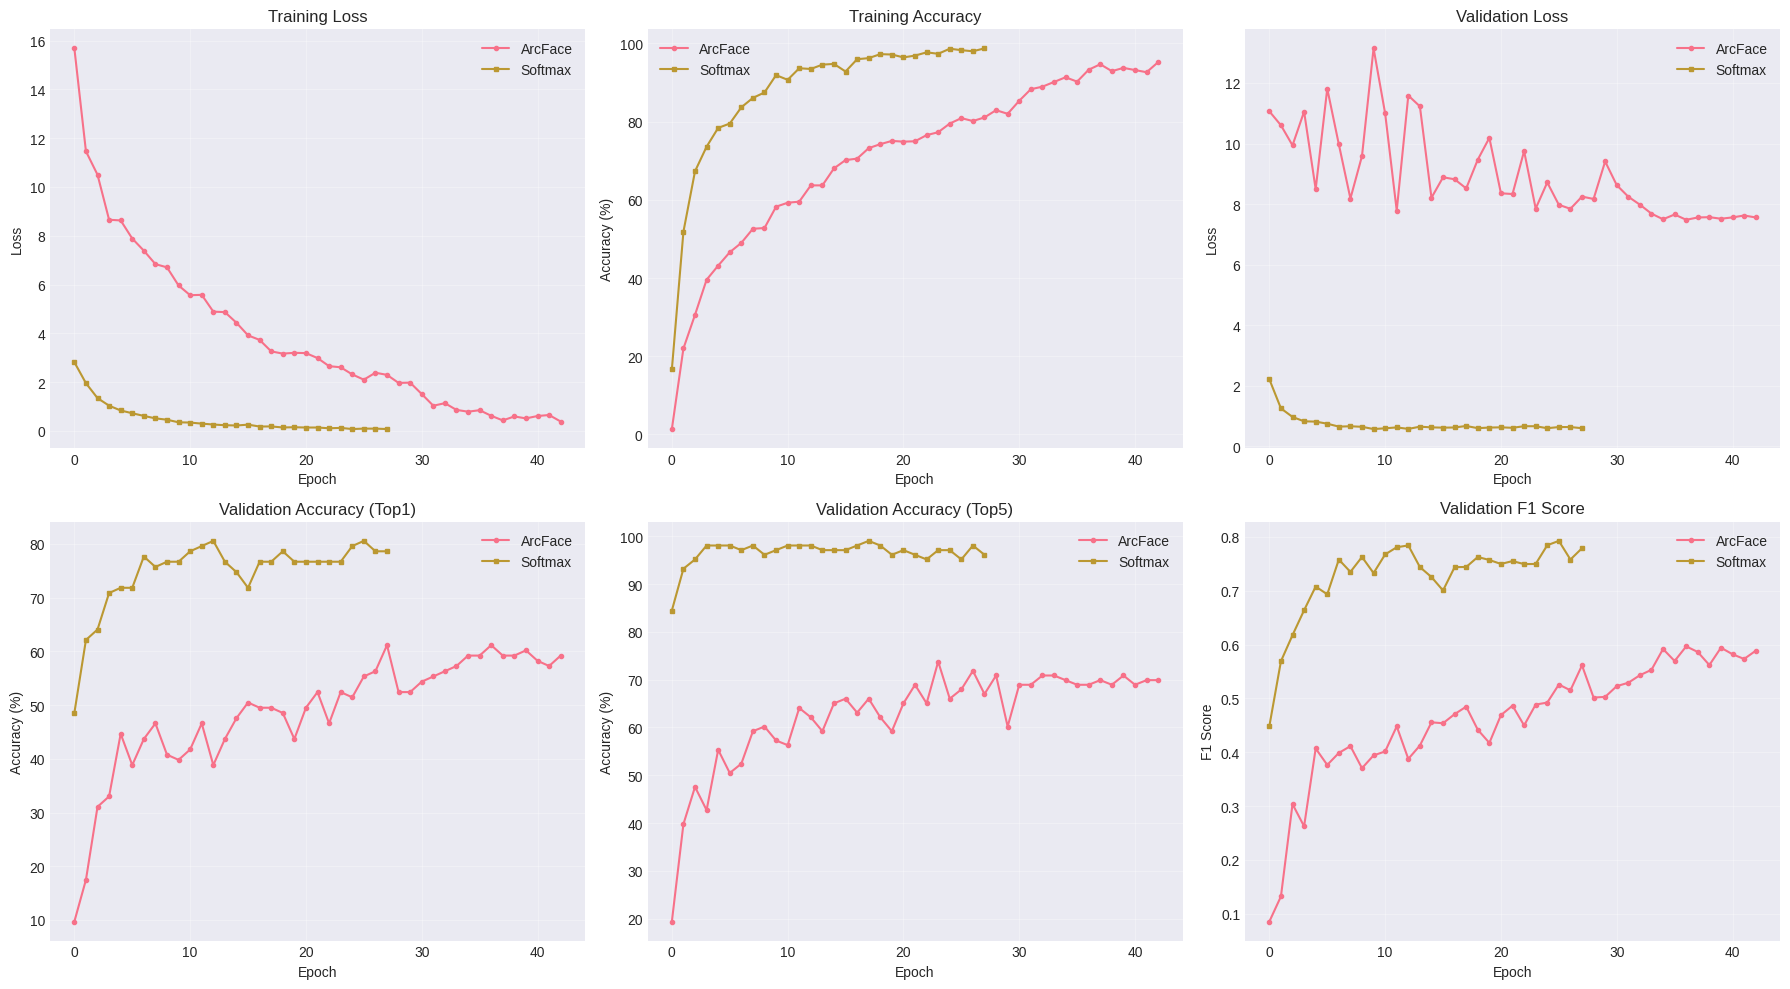

In [21]:
# Plot training history comparison
fig, axes = plt.subplots(2, 3, figsize=(18, 10))

# Training loss
axes[0, 0].plot(history_arcface['train_loss'], label='ArcFace', marker='o', markersize=3)
axes[0, 0].plot(history_softmax['train_loss'], label='Softmax', marker='s', markersize=3)
axes[0, 0].set_xlabel('Epoch')
axes[0, 0].set_ylabel('Loss')
axes[0, 0].set_title('Training Loss')
axes[0, 0].legend()
axes[0, 0].grid(True, alpha=0.3)

# Training accuracy
axes[0, 1].plot(history_arcface['train_acc'], label='ArcFace', marker='o', markersize=3)
axes[0, 1].plot(history_softmax['train_acc'], label='Softmax', marker='s', markersize=3)
axes[0, 1].set_xlabel('Epoch')
axes[0, 1].set_ylabel('Accuracy (%)')
axes[0, 1].set_title('Training Accuracy')
axes[0, 1].legend()
axes[0, 1].grid(True, alpha=0.3)

# Validation loss
axes[0, 2].plot(history_arcface['val_loss'], label='ArcFace', marker='o', markersize=3)
axes[0, 2].plot(history_softmax['val_loss'], label='Softmax', marker='s', markersize=3)
axes[0, 2].set_xlabel('Epoch')
axes[0, 2].set_ylabel('Loss')
axes[0, 2].set_title('Validation Loss')
axes[0, 2].legend()
axes[0, 2].grid(True, alpha=0.3)

# Validation accuracy
axes[1, 0].plot(history_arcface['val_acc'], label='ArcFace', marker='o', markersize=3)
axes[1, 0].plot(history_softmax['val_acc'], label='Softmax', marker='s', markersize=3)
axes[1, 0].set_xlabel('Epoch')
axes[1, 0].set_ylabel('Accuracy (%)')
axes[1, 0].set_title('Validation Accuracy (Top1)')
axes[1, 0].legend()
axes[1, 0].grid(True, alpha=0.3)

# Top5 accuracy
axes[1, 1].plot(np.array(history_arcface['val_top5'])*100, label='ArcFace', marker='o', markersize=3)
axes[1, 1].plot(np.array(history_softmax['val_top5'])*100, label='Softmax', marker='s', markersize=3)
axes[1, 1].set_xlabel('Epoch')
axes[1, 1].set_ylabel('Accuracy (%)')
axes[1, 1].set_title('Validation Accuracy (Top5)')
axes[1, 1].legend()
axes[1, 1].grid(True, alpha=0.3)

# F1 Score
axes[1, 2].plot(history_arcface['val_f1'], label='ArcFace', marker='o', markersize=3)
axes[1, 2].plot(history_softmax['val_f1'], label='Softmax', marker='s', markersize=3)
axes[1, 2].set_xlabel('Epoch')
axes[1, 2].set_ylabel('F1 Score')
axes[1, 2].set_title('Validation F1 Score')
axes[1, 2].legend()
axes[1, 2].grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig(f'{RESULTS_DIR}/training_comparison.png', dpi=150, bbox_inches='tight')
plt.show()

In [22]:
# Final evaluation on validation set
print("\n" + "="*70)
print("FINAL VALIDATION RESULTS")
print("="*70)

# Evaluate ArcFace
_, _, val_preds_arc, val_labels_arc, val_probs_arc = validate(
    model_arcface, val_loader, config.device, 'arcface'
)
metrics_arc = compute_metrics(val_labels_arc, val_preds_arc, val_probs_arc, 'arcface')

# Evaluate Softmax
_, _, val_preds_soft, val_labels_soft, val_probs_soft = validate(
    model_softmax, val_loader, config.device, 'softmax'
)
metrics_soft = compute_metrics(val_labels_soft, val_preds_soft, val_probs_soft, 'softmax')

# Create comparison table
comparison_data = {
    'Metric': ['Top1', 'Top5', 'Precision', 'Recall', 'F1-Score'],
    'ResNet50+Softmax': [
        f"{metrics_soft['top1']*100:.2f}%",
        f"{metrics_soft['top5']*100:.2f}%",
        f"{metrics_soft['precision']:.4f}",
        f"{metrics_soft['recall']:.4f}",
        f"{metrics_soft['f1']:.4f}"
    ],
    'ResNet50+ArcFace': [
        f"{metrics_arc['top1']*100:.2f}%",
        f"{metrics_arc['top5']*100:.2f}%",
        f"{metrics_arc['precision']:.4f}",
        f"{metrics_arc['recall']:.4f}",
        f"{metrics_arc['f1']:.4f}"
    ],
    'Improvement': [
        f"{(metrics_arc['top1'] - metrics_soft['top1'])*100:+.2f}%",
        f"{(metrics_arc['top5'] - metrics_soft['top5'])*100:+.2f}%",
        f"{(metrics_arc['precision'] - metrics_soft['precision']):+.4f}",
        f"{(metrics_arc['recall'] - metrics_soft['recall']):+.4f}",
        f"{(metrics_arc['f1'] - metrics_soft['f1']):+.4f}"
    ]
}

comparison_df = pd.DataFrame(comparison_data)
print("\n", comparison_df.to_string(index=False))

# ArcFace threshold-based accuracy
print("\n" + "-"*70)
print("ResNet50+ArcFace Threshold-Based Accuracy:")
print("-"*70)
threshold_data = []
for threshold in [0.7, 0.8, 0.9, 0.95]:
    top1_t = metrics_arc.get(f'top1_{threshold}', 0)
    prop_t = metrics_arc.get(f'prop_{threshold}', 0)
    threshold_data.append({
        'Threshold': threshold,
        'Top1 Accuracy': f"{top1_t*100:.2f}%",
        'Samples Above Threshold': f"{prop_t*100:.2f}%"
    })

threshold_df = pd.DataFrame(threshold_data)
print("\n", threshold_df.to_string(index=False))

# Save results
comparison_df.to_csv(f'{RESULTS_DIR}/model_comparison.csv', index=False)
threshold_df.to_csv(f'{RESULTS_DIR}/arcface_threshold_results.csv', index=False)

print("\n✓ Results saved to", RESULTS_DIR)


FINAL VALIDATION RESULTS


Validation:   0%|          | 0/4 [00:00<?, ?it/s]

Validation:   0%|          | 0/4 [00:00<?, ?it/s]


    Metric ResNet50+Softmax ResNet50+ArcFace Improvement
     Top1           80.58%           61.17%     -19.42%
     Top5           98.06%           66.99%     -31.07%
Precision           0.8069           0.5986     -0.2083
   Recall           0.8156           0.5734     -0.2422
 F1-Score           0.7841           0.5613     -0.2228

----------------------------------------------------------------------
ResNet50+ArcFace Threshold-Based Accuracy:
----------------------------------------------------------------------

  Threshold Top1 Accuracy Samples Above Threshold
      0.70        62.89%                  94.17%
      0.80        64.89%                  91.26%
      0.90        65.22%                  89.32%
      0.95        65.88%                  82.52%

✓ Results saved to /content/drive/MyDrive/bird_results


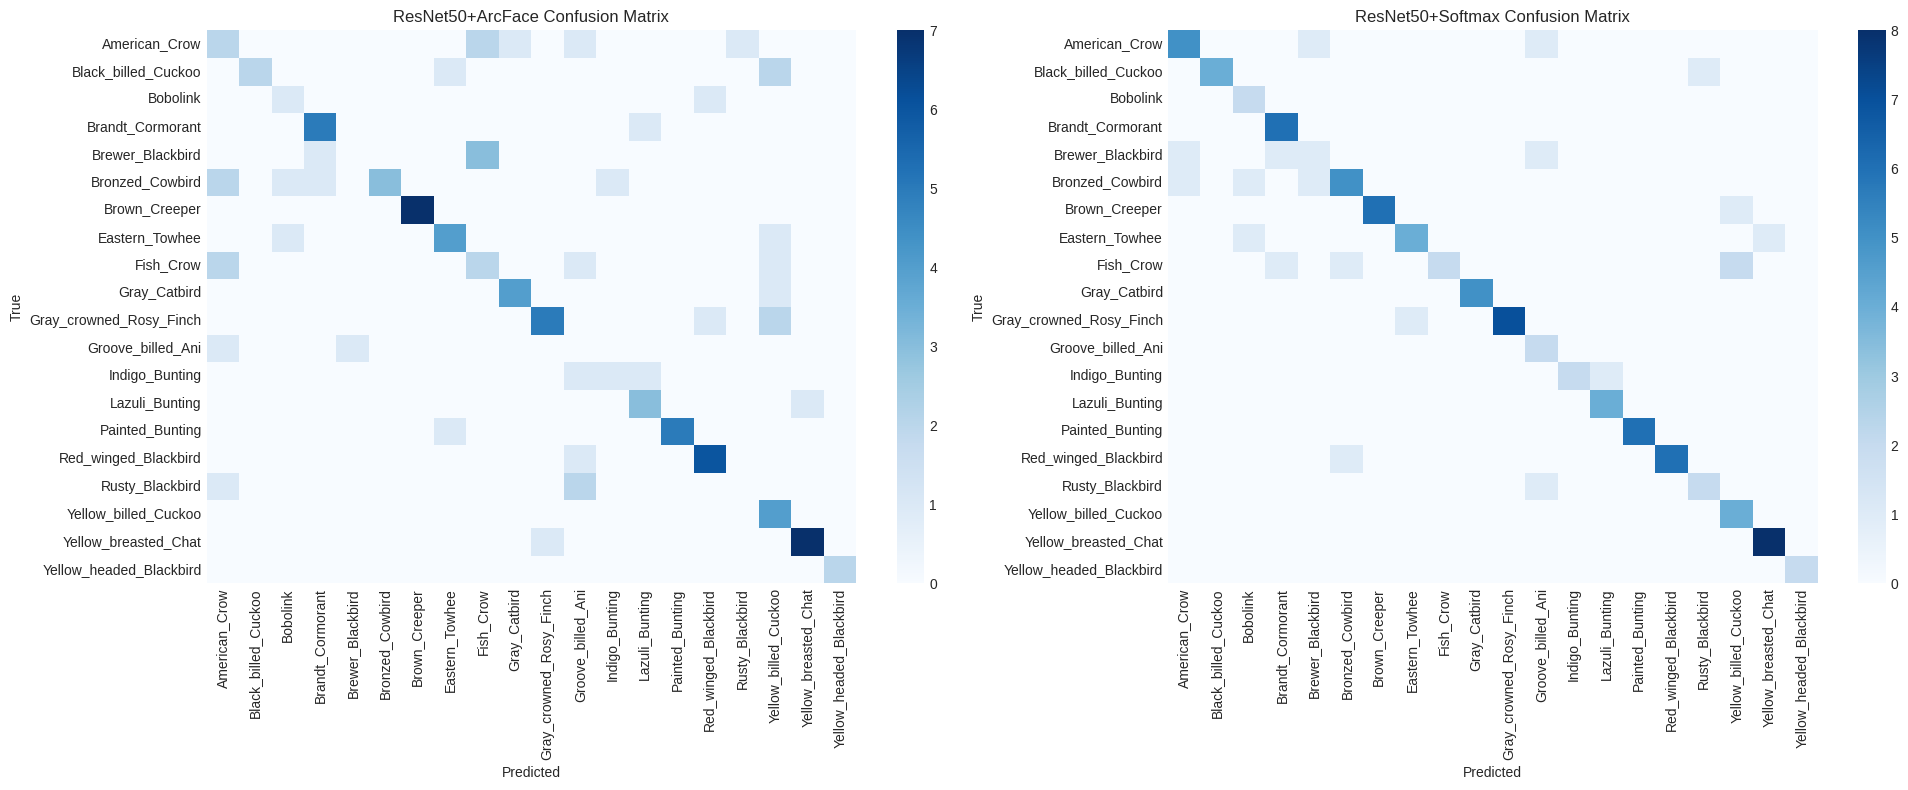

In [23]:
# Confusion matrices
fig, axes = plt.subplots(1, 2, figsize=(20, 8))

# ArcFace confusion matrix
cm_arc = confusion_matrix(val_labels_arc, val_preds_arc)
sns.heatmap(cm_arc, annot=False, fmt='d', cmap='Blues', ax=axes[0],
            xticklabels=class_names, yticklabels=class_names)
axes[0].set_title('ResNet50+ArcFace Confusion Matrix')
axes[0].set_xlabel('Predicted')
axes[0].set_ylabel('True')

# Softmax confusion matrix
cm_soft = confusion_matrix(val_labels_soft, val_preds_soft)
sns.heatmap(cm_soft, annot=False, fmt='d', cmap='Blues', ax=axes[1],
            xticklabels=class_names, yticklabels=class_names)
axes[1].set_title('ResNet50+Softmax Confusion Matrix')
axes[1].set_xlabel('Predicted')
axes[1].set_ylabel('True')

plt.tight_layout()
plt.savefig(f'{RESULTS_DIR}/confusion_matrices.png', dpi=150, bbox_inches='tight')
plt.show()

## 10. Inference on Test Set

Generate predictions for unlabeled test images using the ArcFace model.

In [ ]:
# Test dataset (unlabeled)
class TestDataset(Dataset):
    def __init__(self, img_dir, transform=None):
        self.img_dir = img_dir
        self.transform = transform
        self.image_paths = sorted([f for f in os.listdir(img_dir) if f.endswith(('.jpg', '.jpeg', '.png'))])

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        img_name = self.image_paths[idx]
        img_path = os.path.join(self.img_dir, img_name)

        image = cv2.imread(img_path)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

        if self.transform:
            augmented = self.transform(image=image)
            image = augmented['image']

        return image, img_name

test_dataset = TestDataset(TEST_IMAGES_DIR, transform=get_val_transforms(config.img_size))
test_loader = DataLoader(test_dataset, batch_size=config.batch_size, shuffle=False, num_workers=config.num_workers)

print(f"✓ Test dataset: {len(test_dataset)} images")

In [ ]:
# Generate predictions
def predict_test_set(model, dataloader, device, idx_to_class, threshold=0.8):
    model.eval()
    predictions = []

    with torch.no_grad():
        for images, img_names in tqdm(dataloader, desc='Predicting'):
            images = images.to(device)

            # Get embeddings
            embeddings = model(images)

            # Get similarity scores
            similarity = model.get_similarity_scores(embeddings)

            # Get top prediction and confidence
            max_sim, pred_idx = torch.max(similarity, dim=1)

            for i, img_name in enumerate(img_names):
                pred_class_idx = pred_idx[i].item()
                pred_class_name = idx_to_class[pred_class_idx]
                confidence = max_sim[i].item()

                # Apply threshold
                if confidence < threshold:
                    pred_class_name = 'unknown'

                predictions.append({
                    'image': img_name,
                    'predicted_class': pred_class_name,
                    'predicted_class_idx': pred_class_idx,
                    'confidence': confidence
                })

    return pd.DataFrame(predictions)

# Generate predictions with threshold=0.8
test_predictions = predict_test_set(model_arcface, test_loader, config.device, idx_to_class, threshold=0.8)

print("\nTest Predictions Sample:")
print(test_predictions.head(10))

# Save predictions
test_predictions.to_csv(f'{RESULTS_DIR}/test_predictions.csv', index=False)
print(f"\n✓ Predictions saved to {RESULTS_DIR}/test_predictions.csv")

# Confidence distribution
plt.figure(figsize=(10, 6))
plt.hist(test_predictions['confidence'], bins=50, edgecolor='black', alpha=0.7)
plt.axvline(0.8, color='red', linestyle='--', label='Threshold=0.8')
plt.xlabel('Confidence (Similarity Score)')
plt.ylabel('Frequency')
plt.title('Test Set Prediction Confidence Distribution')
plt.legend()
plt.grid(True, alpha=0.3)
plt.savefig(f'{RESULTS_DIR}/test_confidence_distribution.png', dpi=150, bbox_inches='tight')
plt.show()

print(f"\nPredictions with confidence >= 0.8: {(test_predictions['confidence'] >= 0.8).sum()} / {len(test_predictions)} ({(test_predictions['confidence'] >= 0.8).mean()*100:.1f}%)")

In [ ]:
# Visualize some test predictions
def visualize_predictions(predictions_df, img_dir, num_samples=12):
    fig, axes = plt.subplots(3, 4, figsize=(16, 12))
    axes = axes.flatten()

    # Sample diverse confidence levels
    high_conf = predictions_df[predictions_df['confidence'] >= 0.9].sample(min(4, len(predictions_df[predictions_df['confidence'] >= 0.9])))
    med_conf = predictions_df[(predictions_df['confidence'] >= 0.7) & (predictions_df['confidence'] < 0.9)].sample(min(4, len(predictions_df[(predictions_df['confidence'] >= 0.7) & (predictions_df['confidence'] < 0.9)])))
    low_conf = predictions_df[predictions_df['confidence'] < 0.7].sample(min(4, len(predictions_df[predictions_df['confidence'] < 0.7])))

    samples = pd.concat([high_conf, med_conf, low_conf]).reset_index(drop=True)

    for idx, ax in enumerate(axes):
        if idx < len(samples):
            row = samples.iloc[idx]
            img_path = os.path.join(img_dir, row['image'])

            if os.path.exists(img_path):
                img = Image.open(img_path).convert('RGB')
                ax.imshow(img)

                color = 'green' if row['confidence'] >= 0.8 else 'orange' if row['confidence'] >= 0.6 else 'red'
                ax.set_title(f"{row['predicted_class']}\nConf: {row['confidence']:.3f}",
                           fontsize=9, color=color)
            else:
                ax.text(0.5, 0.5, 'Image not found', ha='center', va='center')

        ax.axis('off')

    plt.tight_layout()
    return fig

fig = visualize_predictions(test_predictions, TEST_IMAGES_DIR)
plt.savefig(f'{RESULTS_DIR}/test_predictions_visualization.png', dpi=150, bbox_inches='tight')
plt.show()